In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from os import listdir
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
from tensorflow.keras.models import model_from_json
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler,LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools

In [2]:
data_dir='./PlantVillage'


In [3]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [4]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 4122 images belonging to 15 classes.
Found 16516 images belonging to 15 classes.


In [5]:
do_fine_tuning = True

In [6]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 15)                19215     
Total params: 2,277,199
Trainable params: 2,243,087
Non-trainable params: 34,112
_________________________________________________________________


In [7]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [8]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
516/516 [==============================] - 3879s 8s/step - loss: 0.9888 - accuracy: 0.8857 - val_loss: 0.7869 - val_accuracy: 0.9673
Epoch 2/5
516/516 [==============================] - 3271s 6s/step - loss: 0.7828 - accuracy: 0.9641 - val_loss: 0.7304 - val_accuracy: 0.9822
Epoch 3/5
516/516 [==============================] - 3038s 6s/step - loss: 0.7343 - accuracy: 0.9780 - val_loss: 0.7338 - val_accuracy: 0.9756
Epoch 4/5
516/516 [==============================] - 2963s 6s/step - loss: 0.7163 - accuracy: 0.9851 - val_loss: 0.7135 - val_accuracy: 0.9805
Epoch 5/5
516/516 [==============================] - 2964s 6s/step - loss: 0.7042 - accuracy: 0.9871 - val_loss: 0.7021 - val_accuracy: 0.9856


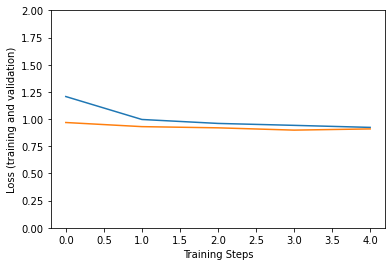

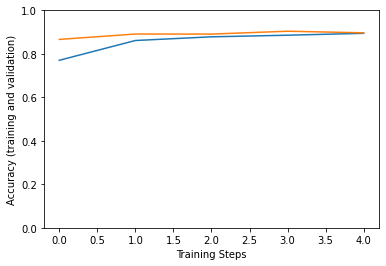

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

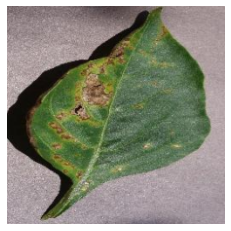

True label: Pepper__bell___Bacterial_spot
Predicted label: Pepper__bell___Bacterial_spot


In [11]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [13]:
saved_model_path = "./tmp/saved_plant_disease_model"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: ./tmp/saved_plant_disease_model\assets


INFO:tensorflow:Assets written to: ./tmp/saved_plant_disease_model\assets


In [20]:

# TODO(b/156102192)
optimize_lite_model = True 

num_calibration_examples = 60  
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("./tmp/lite_plant_disease_model_optimize", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 2940096 bytes.


In [15]:
label=[]
for class_string, class_index in valid_generator.class_indices.items():
    label.append(class_string)
label=np.array(label)

TypeError: Mismatch between array dtype ('<U43') and format specifier ('%.18e')

In [17]:
with open('label.txt', 'w') as f:
    for item in label:
        f.write("%s\n" % item)